<img src="./logo_UTN.svg" align="right" width="150" /> 


<br><br>
#### Procesamiento Digital de Señales

# Trabajo Práctico Nº4
#### Alumno:    Fernando Daniel Fiamberti

# <span style="color:Blue">Introducción</span>
###   Primeras nociones de estimación espectral: Ancho de banda de señales.
 
# <span style="color:Blue">Enunciado</span>
## Consignas:

### En el repositorio PDStestbench encontrará tres tipos de señales registradas:

***Electrocardiograma (ECG).*** En el archivo ECG_TP4.mat encontrará un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas más abajo.

***Pletismografía (PPG).*** El archivo PPG.csv contiene una señal registrada en reposo de un estudiante de la materia que ha donado su registro para esta actividad.

***Audio.*** Tres registros en los que el profesor pronuncia una frase, y otros dos en los que se silba una melodía muy conocida.
Los detalles de cómo acceder a dichos registros los pueden encontrar en lectura_sigs.py

***Se pide:***

***1)*** Realizar la estimación de la densidad espectral de potencia (PSD) de cada señal mediante alguno de los métodos vistos en clase (Periodograma ventaneado, Welch, Blackman-Tukey).

***2)*** Realice una estimación del ancho de banda de cada señal y presente los resultados en un tabla para facilitar la comparación.

***Bonus:***

💎 Proponga algún tipo de señal que no haya sido analizada y repita el análisis. No olvide explicar su origen y cómo fue digitalizada.



# Desarrollo de la tarea

## BONUS: Señal de radio sin modular obtenida de un SDR

### <span style="color:Blue">Código implementado:</span>


Se usarán las 4096 muestras I/Q para el análisis.
La señal se analiza en banda base (-1024.0 kHz a +1024.0 kHz).
Frecuencia central de la portadora: 470.0 MHz
Periodograma calculado en 0.6 segundos
Welch calculado en 0.0 segundos
Blackman-Tukey calculado en 0.1 segundos

Resultados del ancho de banda estimado (Umbral 5% de la potencia máxima en el rango de +/- 100 kHz):
        Método  Frecuencia baja [MHz]  Frecuencia alta [MHz]  Ancho de banda [kHz]
  Periodograma             469.990000             469.990000              0.000000
         Welch             469.988000             469.992000              4.000000
Blackman–Tukey             469.988995             469.990996              2.000977


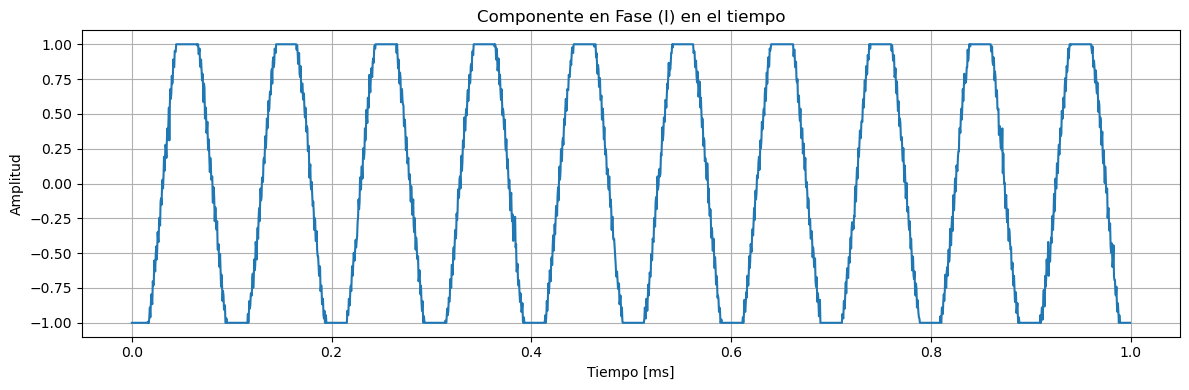

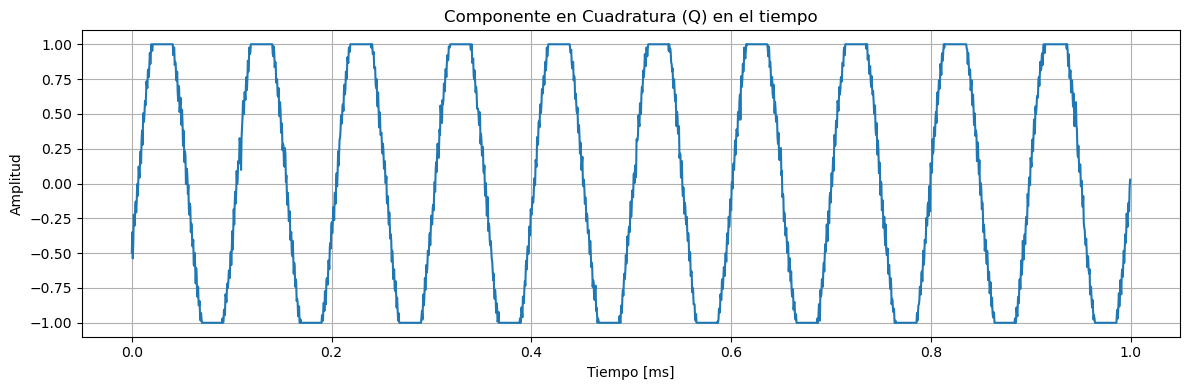

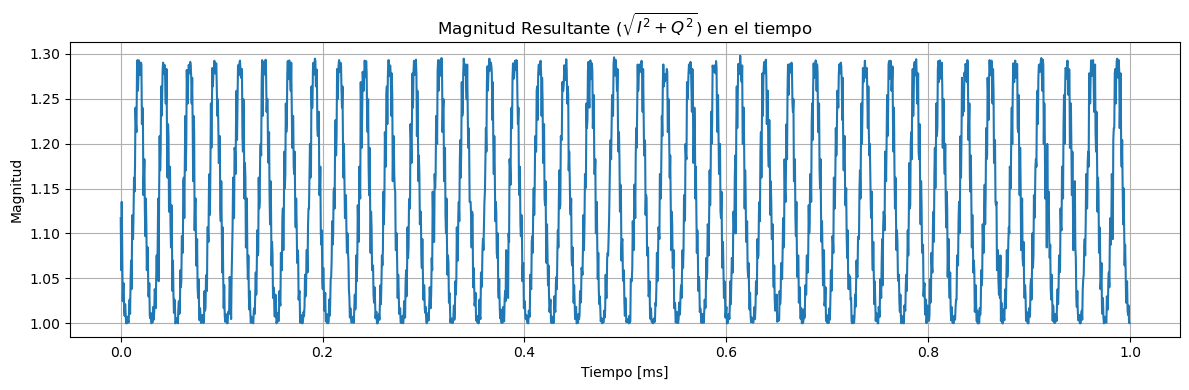

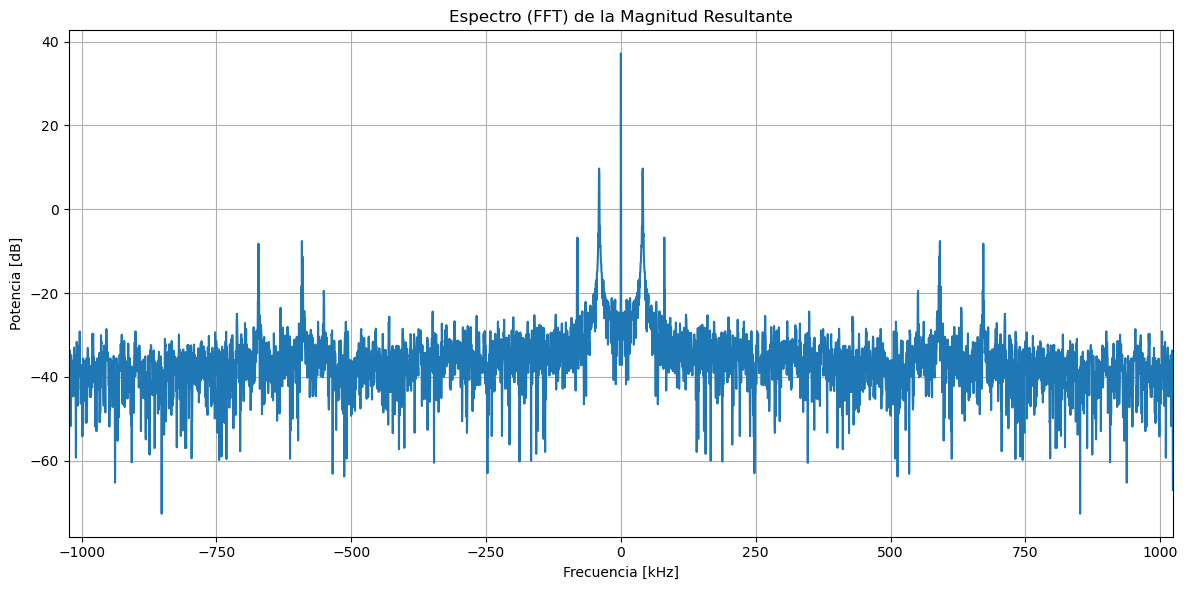

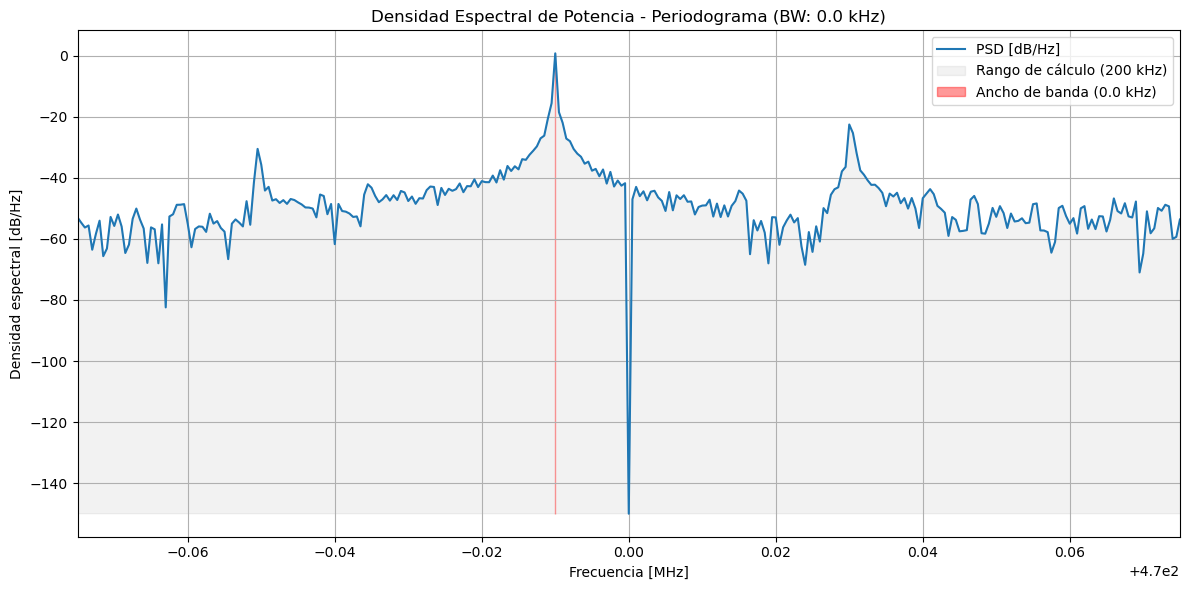

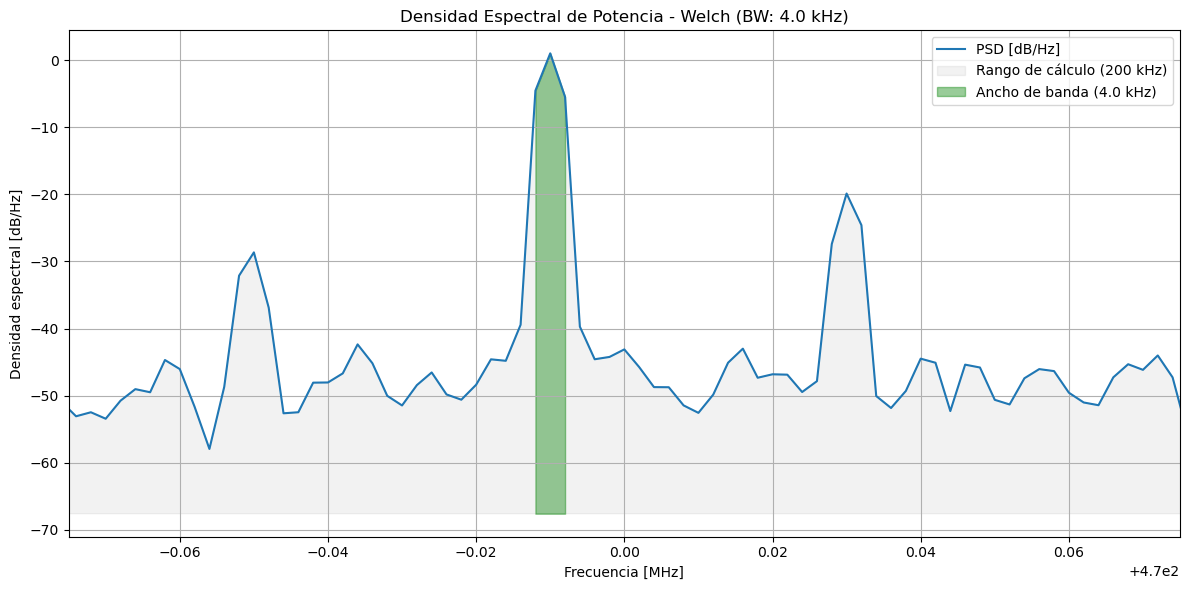

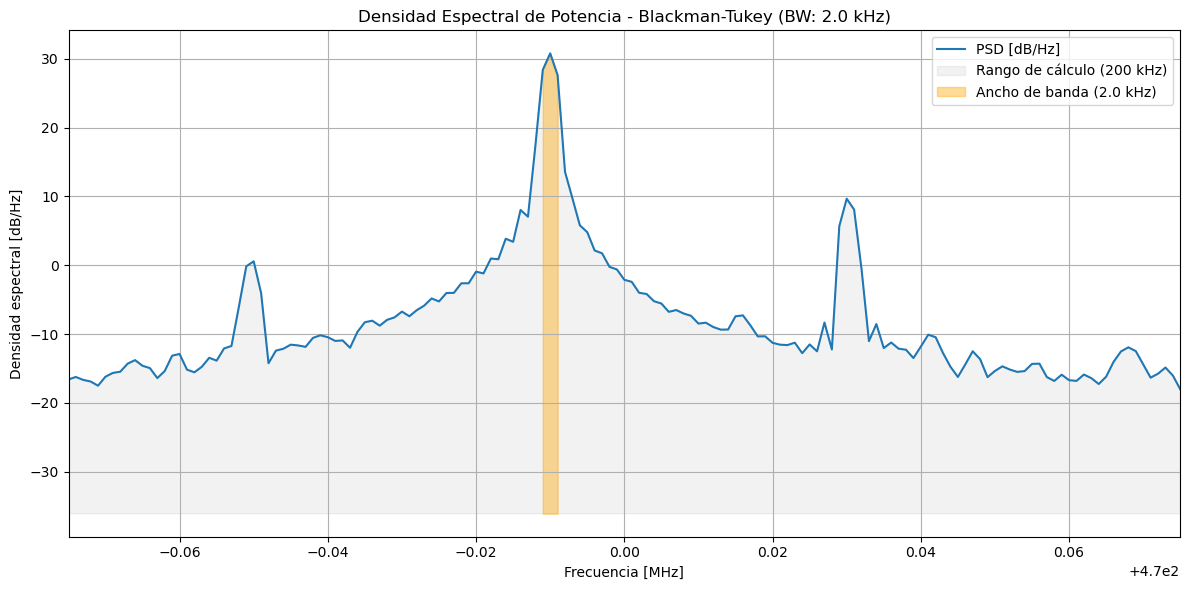

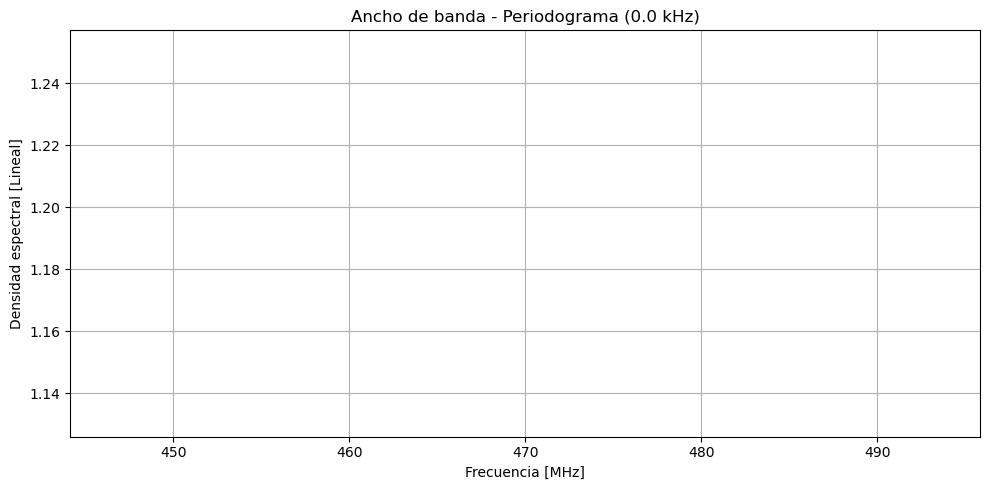

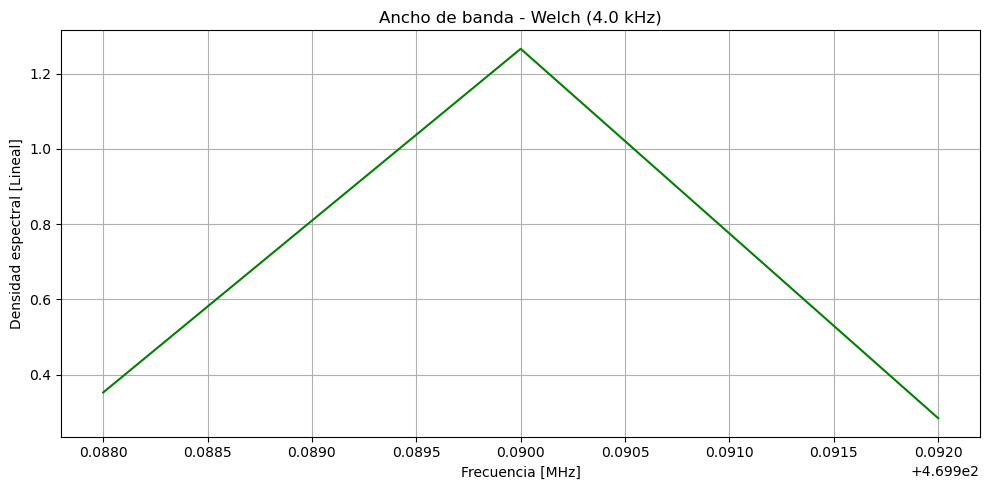

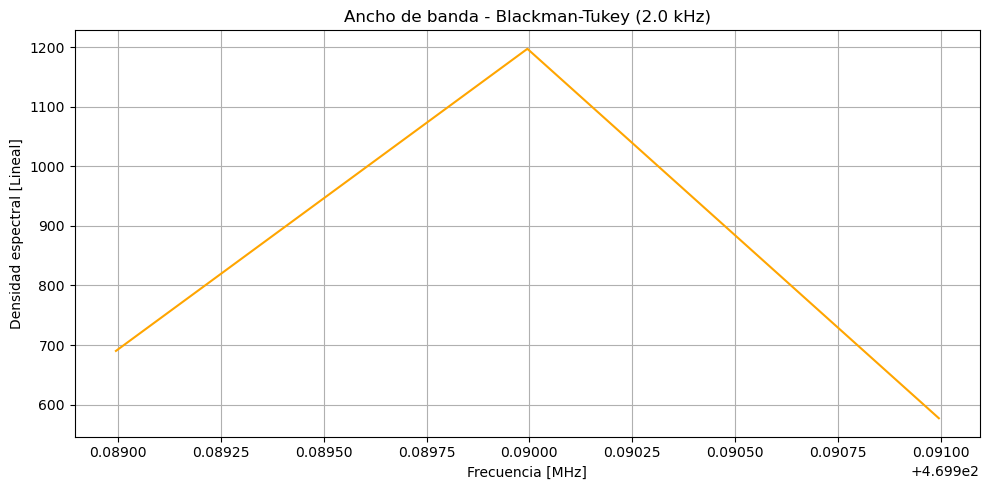

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*
"""
Densidad Espectral de Potencia de la señal de radio sin modular desde CSV

Created on Tue Sep 20 19:49:23 2025

@author: Fernando Daniel Fiamberti

"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram, welch, windows
import pandas as pd
import os
import time

# ----------------------------
# Parámetros de la señal de radio
# ----------------------------
csv_file = 'IQ.csv'           # Archivo CSV con los datos de I/Q
fs = 2.048e6                  # Frecuencia de muestreo en Hz (informativa para PSD)
fft_size = 4096               # Tamaño de la FFT inicial (solo referencia)
N_samples = None              # Usaremos todas las muestras I/Q del CSV
f_center_MHz = 470.0          # Frecuencia central de la portadora en MHz

# --- VARIABLES DE ANCHO DE BANDA ---
bw_zoom_kHz = 75             # Ancho de banda de ZOOM para los gráficos de detalle (+/-)
bw_calc_kHz = 100            # Ancho de banda (+/-) usado para LIMITAR el CALCULO de BW en PSD (100 kHz a cada lado de la portadora).
# -----------------------------------

# --- Rango de visualización de los 3 primeros gráficos (FFT Zoom en el dominio de RF) ---
f_min_MHz = f_center_MHz - (bw_zoom_kHz / 1000)
f_max_MHz = f_center_MHz + (bw_zoom_kHz / 1000)
# --- Rango de cálculo del ancho de banda (en banda base [Hz]) ---
f_calc_low = -bw_calc_kHz * 1000 
f_calc_high = bw_calc_kHz * 1000 

# ----------------------------
# Crear carpeta de resultados si no existe
# ----------------------------
os.makedirs('resultados', exist_ok=True)

# ----------------------------
# Función para calcular ancho de banda
# ----------------------------
def bandwidth(f, Pxx, threshold=0.05, f_low_limit=None, f_high_limit=None):
    """Devuelve la frecuencia mínima, máxima y ancho de banda donde el PSD supera el umbral relativo, dentro de un rango limitado."""
    # Usar PSD lineal para el umbral: 5% del máximo lineal
    Pxx_norm = Pxx / np.max(Pxx)
    mask = Pxx_norm > threshold

    # Aplicar límites de frecuencia
    if f_low_limit is not None:
        mask = mask & (f >= f_low_limit)
    if f_high_limit is not None:
        mask = mask & (f <= f_high_limit)
        
    if np.any(mask):
        f_low = f[mask][0]
        f_high = f[mask][-1]
        bw = f_high - f_low
    else:
        f_low = np.nan
        f_high = np.nan
        bw = np.nan
    return f_low, f_high, bw, mask

# ----------------------------
# Cargar datos I/Q y crear señal COMPLEJA
# ----------------------------
df = pd.read_csv(csv_file)
# CREAR LA SEÑAL COMPLEJA A PARTIR DE LAS COLUMNAS I Y Q y CONVERTIR A NUMPY
I = df['I (In-phase)'].to_numpy()
Q = df['Q (Quadrature)'].to_numpy()
signal_complex = I + 1j * Q
signal_magnitude = np.abs(signal_complex) # Nueva señal de magnitud
N_samples = len(signal_complex)
print(f"Se usarán las {N_samples} muestras I/Q para el análisis.")
print(f"La señal se analiza en banda base (-{fs/2 / 1e3:.1f} kHz a +{fs/2 / 1e3:.1f} kHz).")
print(f"Frecuencia central de la portadora: {f_center_MHz} MHz")

# ===============================================
#       GRÁFICOS TIEMPO Y FFT MAGNITUD
# ===============================================

# --- Parámetros de tiempo para los gráficos ---
t = np.arange(N_samples) / fs
# Mostrar solo una pequeña porción de la señal (1 ms de señal)
N_zoom = int(fs / 1000) 

# --- 1. Señal I en el tiempo ---
plt.figure(figsize=(12, 4))
plt.plot(t[:N_zoom] * 1e3, I[:N_zoom])
plt.title("Componente en Fase (I) en el tiempo")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Amplitud")
plt.grid(True)
plt.tight_layout()
plt.savefig('resultados/01_Senal_I_Tiempo.png', dpi=300)
# plt.show() 

# --- 2. Señal Q en el tiempo ---
plt.figure(figsize=(12, 4))
plt.plot(t[:N_zoom] * 1e3, Q[:N_zoom])
plt.title("Componente en Cuadratura (Q) en el tiempo")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Amplitud")
plt.grid(True)
plt.tight_layout()
plt.savefig('resultados/02_Senal_Q_Tiempo.png', dpi=300)
# plt.show()

# --- 3. Magnitud resultante en el tiempo ---
plt.figure(figsize=(12, 4))
plt.plot(t[:N_zoom] * 1e3, signal_magnitude[:N_zoom])
plt.title("Magnitud Resultante ($\sqrt{I^2 + Q^2}$) en el tiempo")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Magnitud")
plt.grid(True)
plt.tight_layout()
plt.savefig('resultados/03_Magnitud_Tiempo.png', dpi=300)
# plt.show()

# --- 4. FFT de la Magnitud ---
# Calcular FFT de la magnitud
fft_mag = np.fft.fft(signal_magnitude)
f_mag = np.fft.fftfreq(N_samples, 1/fs)
fft_mag = np.fft.fftshift(fft_mag)
f_mag = np.fft.fftshift(f_mag)

plt.figure(figsize=(12, 6))
# Escala logarítmica (dB) para la FFT
Pxx_mag_db = 10 * np.log10(np.abs(fft_mag)**2 / N_samples)
plt.plot(f_mag / 1e3, Pxx_mag_db)
plt.title("Espectro (FFT) de la Magnitud Resultante")
plt.xlabel("Frecuencia [kHz]")
plt.ylabel("Potencia [dB]")
# Limitar el eje x al ancho de banda de la banda base
plt.xlim(-fs/2/1e3, fs/2/1e3) 
plt.grid(True)
plt.tight_layout()
plt.savefig('resultados/04_FFT_Magnitud.png', dpi=300)
# plt.show()

# ===============================================

# ----------------------------
# Periodograma
# ----------------------------
start_time = time.time()
f_per, Pxx_per = periodogram(signal_complex, fs=fs, window='boxcar', scaling='spectrum', return_onesided=False)
f_per = np.fft.fftshift(f_per)
Pxx_per = np.fft.fftshift(Pxx_per)
f_low_per, f_high_per, bw_per, mask_per = bandwidth(f_per, Pxx_per, threshold=0.05, f_low_limit=f_calc_low, f_high_limit=f_calc_high)
end_time = time.time()
print(f"Periodograma calculado en {end_time - start_time:.1f} segundos")

# ----------------------------
# Método de Welch
# ----------------------------
start_time = time.time()
nperseg = 1024
f_w, Pxx_w = welch(signal_complex, fs=fs, window='hann', nperseg=nperseg, noverlap=nperseg//2, scaling='spectrum', return_onesided=False)
f_w = np.fft.fftshift(f_w)
Pxx_w = np.fft.fftshift(Pxx_w)
f_low_w, f_high_w, bw_w, mask_w = bandwidth(f_w, Pxx_w, threshold=0.05, f_low_limit=f_calc_low, f_high_limit=f_calc_high)
end_time = time.time()
print(f"Welch calculado en {end_time - start_time:.1f} segundos")

# ----------------------------
# Método de Blackman-Tukey
# ----------------------------
start_time = time.time()
M = nperseg
# FIX: np.correlate para señales complejas (el original de Numpy no requiere conjugar)
Rxx = np.correlate(signal_complex, signal_complex, mode='full') / N_samples
Rxx_causal = Rxx[N_samples - M:N_samples + M - 1]
window_bt = windows.hann(2 * M - 1)
Rxx_windowed = Rxx_causal * window_bt
Pxx_bt = np.fft.fft(Rxx_windowed)
f_bt = np.fft.fftfreq(len(Pxx_bt), 1/fs)
Pxx_bt = np.abs(Pxx_bt)
f_bt = np.fft.fftshift(f_bt)
Pxx_bt = np.fft.fftshift(Pxx_bt)
f_low_bt, f_high_bt, bw_bt, mask_bt = bandwidth(f_bt, Pxx_bt, threshold=0.05, f_low_limit=f_calc_low, f_high_limit=f_calc_high)
end_time = time.time()
print(f"Blackman-Tukey calculado en {end_time - start_time:.1f} segundos")

# ----------------------------
# Conversión a MHz y kHz para la tabla y gráficos
# ----------------------------
f_center_MHz = f_center_MHz
# Frecuencias en MHz para los gráficos (f_banda_base + f_center)
f_per_MHz = (f_per + f_center_MHz*1e6) / 1e6
f_w_MHz = (f_w + f_center_MHz*1e6) / 1e6
f_bt_MHz = (f_bt + f_center_MHz*1e6) / 1e6

# Límites de BW en MHz (para la tabla)
f_low_per_MHz = (f_low_per + f_center_MHz*1e6) / 1e6
f_high_per_MHz = (f_high_per + f_center_MHz*1e6) / 1e6
f_low_w_MHz = (f_low_w + f_center_MHz*1e6) / 1e6
f_high_w_MHz = (f_high_w + f_center_MHz*1e6) / 1e6
f_low_bt_MHz = (f_low_bt + f_center_MHz*1e6) / 1e6
f_high_bt_MHz = (f_high_bt + f_center_MHz*1e6) / 1e6

# El BW ya está en Hz. Convertir a kHz (para la tabla)
bw_per_kHz = bw_per / 1000
bw_w_kHz = bw_w / 1000
bw_bt_kHz = bw_bt / 1000

# ----------------------------
# Tabla de anchos de banda
# ----------------------------
tabla_bw = pd.DataFrame({
    "Método": ["Periodograma", "Welch", "Blackman–Tukey"],
    "Frecuencia baja [MHz]": [f_low_per_MHz, f_low_w_MHz, f_low_bt_MHz],
    "Frecuencia alta [MHz]": [f_high_per_MHz, f_high_w_MHz, f_high_bt_MHz],
    "Ancho de banda [kHz]": [bw_per_kHz, bw_w_kHz, bw_bt_kHz]
})

print(f"\nResultados del ancho de banda estimado (Umbral 5% de la potencia máxima en el rango de +/- {bw_calc_kHz} kHz):")
print(tabla_bw.to_string(index=False))

# ============================
#    GRÁFICOS PSD
# ============================

# --- PERIOGRAMA ---
plt.figure(figsize=(12, 6))
# Se usa dB/Hz para mejor visualización dinámica
Pxx_per_db = 10 * np.log10(Pxx_per + 1e-15) # +1e-15 para evitar log(0)
plt.plot(f_per_MHz, Pxx_per_db, label='PSD [dB/Hz]') 
plt.fill_between(f_per_MHz, Pxx_per_db.min(), Pxx_per_db, where=(f_per >= f_calc_low) & (f_per <= f_calc_high), color='gray', alpha=0.1, label=f'Rango de cálculo ({2 * bw_calc_kHz} kHz)')
plt.fill_between(f_per_MHz, Pxx_per_db.min(), Pxx_per_db, where=mask_per, color='red', alpha=0.4, label=f'Ancho de banda ({bw_per_kHz:.1f} kHz)')
plt.title(f"Densidad Espectral de Potencia - Periodograma (BW: {bw_per_kHz:.1f} kHz)")
plt.xlabel("Frecuencia [MHz]")
plt.ylabel("Densidad espectral [dB/Hz]")
plt.xlim(f_min_MHz, f_max_MHz)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('resultados/Densidad_Espectral_de_Potencia_periodograma.png', dpi=300)


# --- WELCH ---
plt.figure(figsize=(12, 6))
Pxx_w_db = 10 * np.log10(Pxx_w + 1e-15)
plt.plot(f_w_MHz, Pxx_w_db, label='PSD [dB/Hz]') 
plt.fill_between(f_w_MHz, Pxx_w_db.min(), Pxx_w_db, where=(f_w >= f_calc_low) & (f_w <= f_calc_high), color='gray', alpha=0.1, label=f'Rango de cálculo ({2 * bw_calc_kHz} kHz)')
plt.fill_between(f_w_MHz, Pxx_w_db.min(), Pxx_w_db, where=mask_w, color='green', alpha=0.4, label=f'Ancho de banda ({bw_w_kHz:.1f} kHz)')
plt.title(f"Densidad Espectral de Potencia - Welch (BW: {bw_w_kHz:.1f} kHz)")
plt.xlabel("Frecuencia [MHz]")
plt.ylabel("Densidad espectral [dB/Hz]")
plt.xlim(f_min_MHz, f_max_MHz)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('resultados/Densidad_Espectral_de_Potencia_welch.png', dpi=300)


# --- BLACKMAN-TUKEY ---
plt.figure(figsize=(12, 6))
Pxx_bt_db = 10 * np.log10(Pxx_bt + 1e-15)
plt.plot(f_bt_MHz, Pxx_bt_db, label='PSD [dB/Hz]') 
plt.fill_between(f_bt_MHz, Pxx_bt_db.min(), Pxx_bt_db, where=(f_bt >= f_calc_low) & (f_bt <= f_calc_high), color='gray', alpha=0.1, label=f'Rango de cálculo ({2 * bw_calc_kHz} kHz)')
plt.fill_between(f_bt_MHz, Pxx_bt_db.min(), Pxx_bt_db, where=mask_bt, color='orange', alpha=0.4, label=f'Ancho de banda ({bw_bt_kHz:.1f} kHz)')
plt.title(f"Densidad Espectral de Potencia - Blackman-Tukey (BW: {bw_bt_kHz:.1f} kHz)")
plt.xlabel("Frecuencia [MHz]")
plt.ylabel("Densidad espectral [dB/Hz]")
plt.xlim(f_min_MHz, f_max_MHz)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('resultados/Densidad_Espectral_de_Potencia_blackman_tukey.png', dpi=300)


# --- ZOOM BW Periodograma (Eje Y Lineal) ---
plt.figure(figsize=(10, 5))
plt.plot(f_per_MHz[mask_per], Pxx_per[mask_per], color='red')
plt.title(f"Ancho de banda - Periodograma ({bw_per_kHz:.1f} kHz)")
plt.xlabel("Frecuencia [MHz]")
plt.ylabel("Densidad espectral [Lineal]")
plt.grid(True)
plt.tight_layout()
plt.savefig('resultados/AnchoBanda_Densidad_Espectral_de_Potencia_periodograma.png', dpi=300)


# --- ZOOM BW Welch (Eje Y Lineal) ---
plt.figure(figsize=(10, 5))
plt.plot(f_w_MHz[mask_w], Pxx_w[mask_w], color='green')
plt.title(f"Ancho de banda - Welch ({bw_w_kHz:.1f} kHz)")
plt.xlabel("Frecuencia [MHz]")
plt.ylabel("Densidad espectral [Lineal]")
plt.grid(True)
plt.tight_layout()
plt.savefig('resultados/AnchoBanda_Densidad_Espectral_de_Potencia_welch.png', dpi=300)


# --- ZOOM BW Blackman-Tukey (Eje Y Lineal) ---
plt.figure(figsize=(10, 5))
plt.plot(f_bt_MHz[mask_bt], Pxx_bt[mask_bt], color='orange')
plt.title(f"Ancho de banda - Blackman-Tukey ({bw_bt_kHz:.1f} kHz)")
plt.xlabel("Frecuencia [MHz]")
plt.ylabel("Densidad espectral [Lineal]")
plt.grid(True)
plt.tight_layout()
plt.savefig('resultados/AnchoBanda_Densidad_Espectral_de_Potencia_blackman_tukey.png', dpi=300)

# ----------------------------
# Mostrar todos los gráficos de Matplotlib
# ----------------------------
plt.show()